### Import libraries

In [2]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# read csv with BERTopic Clusters


### Reading original Reddit data to obtain aggregate post counts by year
To be used for normalization 

In [4]:
# reading data
df_all_time=pd.read_csv('data/data_SG_reddit.csv.gz', compression='gzip', index_col=False)
# subseting to the only neccessary column
df_all_time=df_all_time[["created_utc"]]
# converting to datetime
df_all_time["created_utc"]=pd.to_datetime(df_all_time['created_utc'], unit='s')
df_all_time.set_index('created_utc', inplace=True)
# filtering to 2015 and beyond
df_all_time=df_all_time[df_all_time.index >= '2015-01-01']
print(len(df_all_time))
# aggregating the counts by year
df_all_time = df_all_time.resample('Y').size().fillna(0)
# convert to data
df_all_time=pd.DataFrame(df_all_time)
df_all_time=df_all_time.rename(columns={0: 'total_counts'})

C:\Users\charl\AppData\Local\Temp\ipykernel_29032\2029485315.py:2: DtypeWarning: Columns (1,4,8,12,16,17,19,21,26,30,32,34,35,38,39,40,41,42,43,44,45,46,47,51,54,55,57,58,59,60,61,62,66,67,68,69,72,73,74,77,79,81,82,83,84,85,91,92,93,94,96,97,99,100,101,102,103,104,105,106,107,109,110,111,112,113,115,116,118,120,121,123,124,126,128,129,130,131) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all_time=pd.read_csv('data/data_SG_reddit.csv.gz', compression='gzip', index_col=False)


379787


C:\Users\charl\AppData\Local\Temp\ipykernel_29032\2029485315.py:12: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_all_time = df_all_time.resample('Y').size().fillna(0)


### obtain aggregate topic counts by year

In [6]:
def clean_topic_representation(topic):
    '''
    Parameters:
        topic (str): topic number obtained from BERTopic
    Returns:
        A string from this format: 0_psychiatrist_seek_affordable_attacks to Topic 0: psychiatrist, seek, affordable, attacks
    '''
    parts = topic.split('_')
    # The first part is the numeric index
    index = parts[0]
    # The remaining parts are the words
    words = ', '.join(parts[1:])
    # Format the output as required
    formatted = f"Topic {index}: {words}"
    return(formatted)
# reading data clustered into topics
df=pd.read_csv("document_clusters.csv")
# include only unneccessary columns
list_of_cols=(list(df.columns))[:15]+["created_utc","created","score","author"]
df=df[list_of_cols]
df['created_utc'] = pd.to_datetime(df['created_utc'])
# cleaning the topic names
df["Name"]=df["Name"].apply(clean_topic_representation)
df.set_index('created_utc', inplace=True)
# aggregating the data
df_resampled = df.groupby('Name').resample('YE').size().unstack(level=0).fillna(0)

### Normalizing the counts (by the total number of SG related reddit posts for the year)

In [8]:
# merging the data to get the overall counts and topic counts in the same dataframe 
df_resampled = pd.merge(df_all_time, df_resampled, left_index=True, right_index=True)
topic_cols=[i for i in list(df_resampled.columns) if i!="total_counts"]
# saving the raw count data
df_resampled_raw=df_resampled.drop(columns=['total_counts'], axis=1)
df_resampled_raw.to_csv("data/naggregated_topic.csv", index=False)
# normalizing the data
df_resampled[topic_cols] = df_resampled[topic_cols].div(df_resampled['total_counts'], axis=0)
df_resampled=df_resampled.drop(columns=['total_counts'], axis=1)
df_resampled=df_resampled.mul(1000)
# saving the normalized data
df_resampled.to_csv("data/normalized_aggregated_topic.csv", index=False)

### Plotting

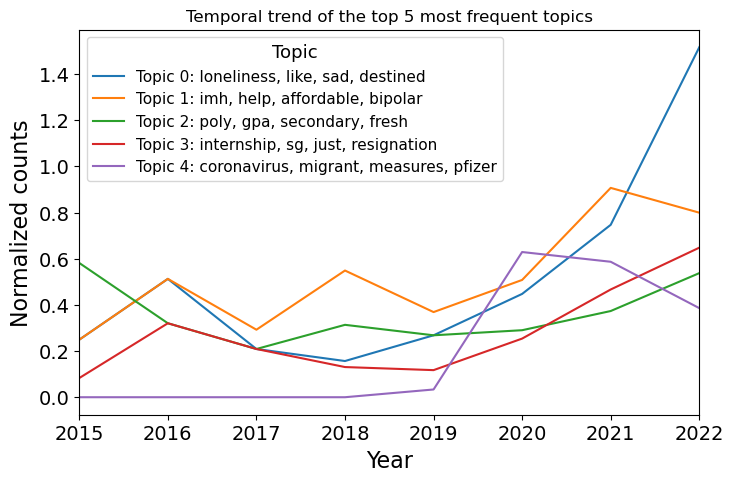

In [10]:

plt.figure(figsize=(8, 5))
ax = plt.gca()
df_filtered = df_resampled.iloc[:, [1, 2,3, 4, 5]]
df_filtered.plot(ax=ax)

plt.title('Temporal trend of the top 5 most frequent topics')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Normalized counts', fontsize=16)
plt.xticks(fontsize=14)  # Adjust x-axis tick font size
plt.yticks(fontsize=14)  # Adjust y-axis tick font size
plt.legend(title='Topic', fontsize=11, title_fontsize=13)

plt.xticks()  # Rotate for better readability
plt.savefig('../plots/plot_topics.png', dpi=1200, bbox_inches='tight') 
plt.show()

In [11]:
df_resampled["Social Isolation & Emotional Struggles"]=df_resampled["Topic 0: loneliness, like, sad, destined"]+df_resampled["Topic 8: breakup, attachment, unavailable, sensitive"]
df_resampled["Career & Educational Pressures"]=df_resampled["Topic 2: poly, gpa, secondary, fresh"]+df_resampled["Topic 3: internship, sg, just, resignation"]+df_resampled["Topic 6: pes, nsf, bunk, depression"]
df_resampled["Access & Support to Health Services"]=df_resampled["Topic 1: imh, help, affordable, bipolar"]+df_resampled["Topic 5: attacks, eating, ptsd, antidepressants"]
df_resampled["Tragedies from Personal & Global Events"]=df_resampled["Topic 4: coronavirus, migrant, measures, pfizer"]+df_resampled["Topic 7: heard, shes, assaulted, families"]+df_resampled["Topic 9: scam, valuing, transactions, ocbc"]

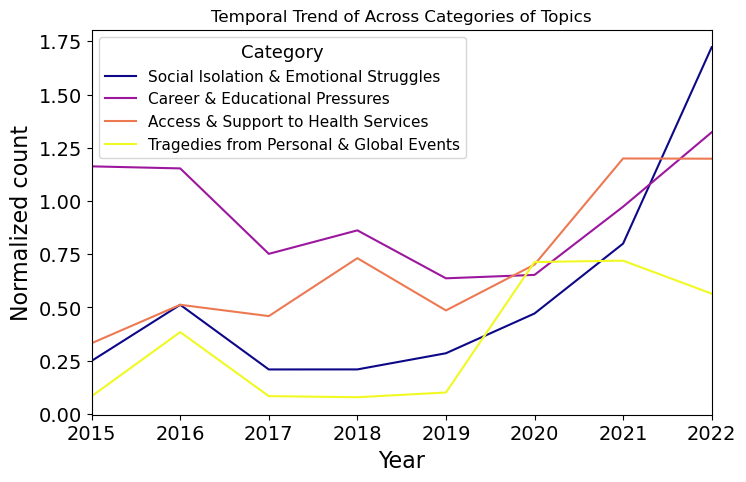

In [12]:
# Assuming 'created_utc' is already in datetime format
# Set 'created_utc' as the index if it isn't already
df_filtered = df_resampled.iloc[:, -4:]

# Plotting
plt.figure(figsize=(8, 5))
ax2 = plt.gca()
df_filtered.plot(ax=ax2, colormap='plasma')

plt.title('Temporal Trend of Across Categories of Topics')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Normalized count', fontsize=16)
# Customizing tick label size
plt.xticks(fontsize=14)  # Adjust x-axis tick font size
plt.yticks(fontsize=14)  # Adjust y-axis tick font size
plt.legend(title='Category', fontsize=11, title_fontsize=13)
plt.savefig('../plots/plot_categories.png', dpi=1200, bbox_inches='tight') 
plt.show()